In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

> ### Visualize Class

Generate images that maximise the class probability, and visualize what does that class look like for the model.

#### Data

In [162]:
numbers = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = numbers.load_data()

In [163]:
print(f'Training set shape: X:{X_train.shape}, y:{y_train.shape}')
print(f'Test set shape: X:{X_test.shape}, y:{y_test.shape}')
print(f'There are {len(np.unique(y_train))} labels: {np.unique(y_train)}')

Training set shape: X:(60000, 28, 28), y:(60000,)
Test set shape: X:(10000, 28, 28), y:(10000,)
There are 10 labels: [0 1 2 3 4 5 6 7 8 9]


Class 9


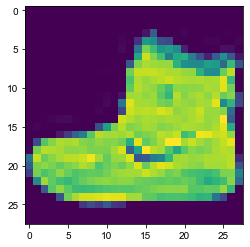

In [164]:
plt.imshow(X_train[0])
print(f'Class {y_train[0]}')

In [165]:
def preprocess(images): # for numpy arrays
    images = images.astype('float32') 
    images = images/255.0 
    images = images.reshape(-1,28,28,1) 
    return images

In [166]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

#### Model

In [15]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, #kernal_size可以简写成3
                  padding="same", activation='relu', 
                  input_shape=(28,28,1), #keras默认忽略第一个维度，即m/batch_size，所以为None
                  kernel_regularizer='l2'), #kernel_regularizer=regularizers.l2(l2=0.01)
    layers.BatchNormalization(axis=-1),
    layers.MaxPooling2D(pool_size=(2,2), # 高宽各减半的池化层，可以简写为2
                        strides=2), # strides默认和pool_size一样
    layers.Conv2D(64, 3, 1, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Flatten(), # 打平层，方便全连接层处理
    layers.Dense(128, activation='relu'), # 全连接层，128个节点
    layers.Dense(10, activation='softmax'), 
])

In [17]:
model.compile(optimizer='sgd', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1) #默认32samples/batch

Epoch 1/5
1688/1688 [==============================] - 116s 68ms/step - loss: 0.1706 - accuracy: 0.9544 - val_loss: 0.0753 - val_accuracy: 0.9835
Epoch 2/5
1688/1688 [==============================] - 115s 68ms/step - loss: 0.0705 - accuracy: 0.9826 - val_loss: 0.0572 - val_accuracy: 0.9890
Epoch 3/5
1688/1688 [==============================] - 113s 67ms/step - loss: 0.0525 - accuracy: 0.9873 - val_loss: 0.0607 - val_accuracy: 0.9857
Epoch 4/5
1688/1688 [==============================] - 114s 67ms/step - loss: 0.0421 - accuracy: 0.9896 - val_loss: 0.0475 - val_accuracy: 0.9893
Epoch 5/5
1688/1688 [==============================] - 118s 70ms/step - loss: 0.0356 - accuracy: 0.9911 - val_loss: 0.0466 - val_accuracy: 0.9895


#### Generator

In [124]:
#改变随机图片，使得模型认为它是某个类别
model.trainable=False
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()


def train_step(image, target):
    with tf.GradientTape() as tape:
        y_pred = model(image)
        loss = loss_object(target, y_pred)
    gradients = tape.gradient(loss, image) 
    optimizer.apply_gradients([(gradients, image)]) 
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return loss

def visualize_class(image, target, epochs=1):
    image0 = tf.constant(image) #原始随机状态
    for e in range(epochs):
        loss = train_step(image,target)
        if e%20==0:
            y_pred = model(image)[0][target] #预测为target label的概率
            print(f'Epoch {e+1}/{epochs} - loss: {loss.numpy():,.4f} - y_prob: {y_pred:.2f}') #在进度条前的描述
    
    plt.subplot(1,2,1)
    plt.imshow(image0[0]) #最初随机
    plt.title(f'Random: y_pred = {np.argmax(model(image0)[0])}')
    plt.subplot(1,2,2)
    plt.imshow(image[0]) #显示最终生成的图片
    plt.title(f'Final: y_pred = {np.argmax(model(image)[0])}')
    plt.show()
    return image

Epoch 1/100 - loss: 5.0261 - y_prob: 0.01
Epoch 21/100 - loss: 0.0171 - y_prob: 0.99
Epoch 41/100 - loss: 0.0054 - y_prob: 0.99
Epoch 61/100 - loss: 0.0043 - y_prob: 1.00
Epoch 81/100 - loss: 0.0038 - y_prob: 1.00


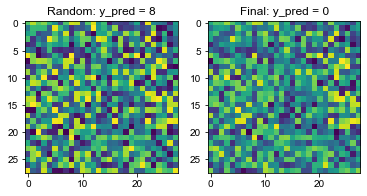

In [171]:
#生成模型心中类别target的样子
target = 0
image0 = tf.Variable(np.random.rand(1,28,28,1), dtype=tf.float32)
image = visualize_class(image0, target, epochs=100)

Try another way to make the result readable by humans.

In [159]:
def generator_model():
    generator = keras.Sequential([
        layers.Dense(64, activation="selu", input_shape=[NOISE_DIM]),
        layers.Dense(128, activation="selu"),
        layers.Dense(28*28, activation="sigmoid"), #生成[0,1]图片数据
        layers.Reshape([28, 28, 1]) #(m,h,w,c)
    ], name='Generator')
    return generator

def visualize_class_model(generator, model):
    inputs = keras.Input(shape=[NOISE_DIM])
    x = generator(inputs)
    outputs = model(x)
    visualize_class = keras.Model(inputs, outputs)
    return visualize_class

NOISE_DIM = 50
generator = generator_model()
visualize_model = visualize_class_model(generator, model)
visualize_model.summary()
visualize_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
Generator (Sequential)       (None, 28, 28, 1)         112720    
_________________________________________________________________
sequential (Sequential)      (None, 10)                334154    
Total params: 446,874
Trainable params: 112,720
Non-trainable params: 334,154
_________________________________________________________________


In [187]:
#生成人类认为模型心中类别target的样子
target = np.array([[5]])
noise = np.random.normal(size=[1, NOISE_DIM])
image0 = generator(noise)
history = visualize_model.fit(noise, target, epochs=10, verbose=1)

Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 3.8179
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 1.3642
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1934
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0460
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0112
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0107


<AxesSubplot:>

Text(0.5, 1.0, 'Random: y_pred = 3')

<AxesSubplot:>

Text(0.5, 1.0, 'Final: y_pred = 5')

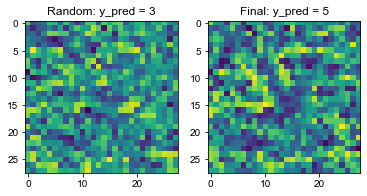

In [188]:
image = generator(noise)
plt.subplot(1,2,1)
plt.imshow(image0[0]) #最初随机
plt.title(f'Random: y_pred = {np.argmax(model(image0)[0])}')
plt.subplot(1,2,2)
plt.imshow(image[0]) #显示最终生成的图片
plt.title(f'Final: y_pred = {np.argmax(model(image)[0])}')
plt.show()